In [1]:
#Import libraries to access data from Google Drive
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Import libraries for data manipulation and for tuning, training and assessing the LR model
import numpy as np
import pandas as pd
import time
from numpy import mean
from numpy import std
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#Import libraries to plot the results
import matplotlib.pyplot as plt
import itertools

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':"1rJUCyDztqA321Uo690atZCQYS8Q1Y6XN"})
downloaded.GetContentFile('preprocessed_data.csv')
data_ready = pd.read_csv('preprocessed_data.csv')

In [3]:
#print(data_ready['category'].value_counts())
cat_index = data_ready['category'].value_counts().index

In [60]:
def create_lr_model():
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 10000)
    return model

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', xsize=4, ysize=3,
                          cmap=None, normalize=True, name='prova'):
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(xsize, ysize))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
  #  plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.3f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.3f}; misclass={:0.3f}'.format(accuracy, misclass))
    filename = name + '.png'
    plt.savefig(filename, bbox_inches = 'tight')

Set 0

In [52]:
select_data = data_ready[data_ready['category'].isin(cat_index[0:3])].dropna().reset_index(drop=True)
print(select_data['category'].value_counts())

#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(select_data["clean_text"], select_data["category"], random_state = 1000,
                                                    stratify = select_data["category"], test_size=0.2, shuffle=True)

#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train = tfidf_vectorizer.fit_transform(X_train) 
X_test = tfidf_vectorizer.transform(X_test)

X_train.sort_indices()
X_test.sort_indices()

hep-ph      50603
quant-ph    44678
hep-th      39013
Name: category, dtype: int64


Tune regularization for multinomial logistic regression

In [ ]:
model = create_lr_model()

# define the grid search parameters
cand_pt = ['none', 'l2']
cand_rs = [0.0001, 0.001, 0.01, 0.1, 1.0]
#cand_mi = [10, 100, 1000, 10000][1:2]

param_grid0 = dict(penalty=cand_pt[1:2], C=cand_rs)
param_grid1 = dict(penalty=cand_pt[0:1])

grid0 = GridSearchCV(estimator=model, param_grid=param_grid0, n_jobs=-1, cv=5)
grid1 = GridSearchCV(estimator=model, param_grid=param_grid1, n_jobs=-1, cv=5)

In [ ]:
s = time.time()
grid_results_l2 = grid0.fit(X_train, y_train)
f = time.time()
el_t = f-s

cv_results_l2 = pd.DataFrame.from_dict(grid_results_l2.cv_results_)

print("Best accuracy with l2 regularization: %f using %s" % (grid_results_l2.best_score_, grid_results_l2.best_params_))
print("\n")
print("Time needed for the estimation: %f" % (el_t))

Best accuracy with l2 regularization: 0.950835 using {'C': 1.0, 'penalty': 'l2'}


Time needed for the estimation: 240.488342


In [ ]:
s = time.time()
grid_results_noreg = grid1.fit(X_train, y_train)
f = time.time()
el_t = f-s

cv_results_noreg = pd.DataFrame.from_dict(grid_results_noreg.cv_results_)

print("Best accuracy without regularization: %f using %s" % (grid_results_noreg.best_score_, grid_results_noreg.best_params_))
print("\n")
print("Time needed for the estimation: %f" % (el_t))

Best accuracy without regularization: 0.927221 using {'penalty': 'none'}


Time needed for the estimation: 429.227810


In [ ]:
cv_results = pd.concat([cv_results_l2, cv_results_noreg]).reset_index(drop=True)
cv_results = cv_results.sort_values(by=['mean_test_score'], ascending=False)
cv_results_set0_lr = cv_results.drop(['std_fit_time', 'std_score_time', 'params', 'split0_test_score', 'split1_test_score', 
                              'split2_test_score', 'split3_test_score', 'split4_test_score', 'rank_test_score'], 1)
cv_results_set0_lr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


,mean_fit_time,mean_score_time,param_C,param_penalty,mean_test_score,std_test_score
4,35.505407,0.055061,1.0,l2,0.950835,0.000866
3,18.735413,0.062525,0.1,l2,0.941537,0.001754
2,9.915868,0.062417,0.01,l2,0.929232,0.001810
5,79.519181,0.058207,NaN,none,0.927221,0.001160
1,5.870612,0.101452,0.001,l2,0.871606,0.001901
0,3.003658,0.060814,0.0001,l2,0.386652,0.000318


In [ ]:
cv_results_set0_lr.to_csv('cv_results_set0_lr.csv', encoding = 'utf-8-sig') 
files.download('cv_results_set0_lr.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
#MULTINOMIAL LOGISTIC REGRESSION with tuned hyperparameters

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=1, max_iter = 10000)

# make a prediction with a multinomial logistic regression model
# fit the model on the whole dataset
model.fit(X_train, y_train)
# define a single row of input data
X_test0 = X_test
yhat0 = model.predict(X_test0)
y_test0 = y_test

Accuracy: 0.953


Accuracy: 0.953


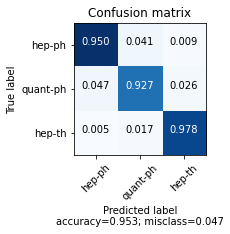

In [61]:
#Accuracy score
acc = accuracy_score(y_test0, yhat0)
print('Accuracy: %.3f' % round(acc, 3))

#Confusion matrix
conf = confusion_matrix(y_test0, yhat0)
plot_confusion_matrix(conf, cat_index[:3], name='lr0')

Set 1

In [55]:
select_data = data_ready[data_ready['category'].isin(cat_index[4:9])].reset_index(drop=True)
print(select_data['category'].value_counts())

#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(select_data["clean_text"], select_data["category"], random_state = 1000,
                                                    stratify = select_data["category"], test_size=0.2, shuffle=True)

#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train = tfidf_vectorizer.fit_transform(X_train) 
X_test = tfidf_vectorizer.transform(X_test)

stat       19868
math-ph    17597
nucl-th    13730
q-bio      13316
hep-ex     10158
Name: category, dtype: int64


In [ ]:
s = time.time()
grid_results_l2 = grid0.fit(X_train, y_train)
f = time.time()
el_t = f-s

cv_results_l2 = pd.DataFrame.from_dict(grid_results_l2.cv_results_)

print("Best accuracy with l2 regularization: %f using %s" % (grid_results_l2.best_score_, grid_results_l2.best_params_))
print("\n")
print("Time needed for the estimation: %f" % (el_t))

Best accuracy with l2 regularization: 0.951134 using {'C': 1.0, 'penalty': 'l2'}


Time needed for the estimation: 262.530915


In [ ]:
s = time.time()
grid_results_noreg = grid1.fit(X_train, y_train)
f = time.time()
el_t = f-s

cv_results_noreg = pd.DataFrame.from_dict(grid_results_noreg.cv_results_)

print("Best accuracy without regularization: %f using %s" % (grid_results_noreg.best_score_, grid_results_noreg.best_params_))
print("\n")
print("Time needed for the estimation: %f" % (el_t))

Best accuracy without regularization: 0.943283 using {'penalty': 'none'}


Time needed for the estimation: 149.720491


In [ ]:
cv_results = pd.concat([cv_results_l2, cv_results_noreg]).reset_index(drop=True)
cv_results = cv_results.sort_values(by=['mean_test_score'], ascending=False)
cv_results_set1_lr = cv_results.drop(['std_fit_time', 'std_score_time', 'params', 'split0_test_score', 'split1_test_score', 
                              'split2_test_score', 'split3_test_score', 'split4_test_score', 'rank_test_score'], 1)
cv_results_set1_lr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


,mean_fit_time,mean_score_time,param_C,param_penalty,mean_test_score,std_test_score
4,44.520727,0.043136,1.0,l2,0.951134,0.001597
5,39.871834,0.043930,NaN,none,0.943283,0.001642
3,21.763471,0.059046,0.1,l2,0.937256,0.001387
2,9.952703,0.041080,0.01,l2,0.889311,0.002012
1,3.619491,0.041293,0.001,l2,0.469808,0.001960
0,2.107833,0.039040,0.0001,l2,0.266075,0.000033


In [ ]:
cv_results_set1_lr.to_csv('cv_results_set1_lr.csv', encoding = 'utf-8-sig') 
files.download('cv_results_set1_lr.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [56]:
#MULTINOMIAL LOGISTIC REGRESSION with tuned hyperparameters

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=1, max_iter = 10000)

# make a prediction with a multinomial logistic regression model
# fit the model on the whole dataset
model.fit(X_train, y_train)
# define a single row of input data
X_test1 = X_test
yhat1 = model.predict(X_test1)
y_test1 = y_test

Accuracy: 0.955


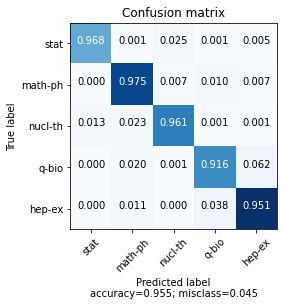

In [57]:
#Accuracy score
acc = accuracy_score(y_test1, yhat1)
print('Accuracy: %.3f' % round(acc, 3))

#Confusion matrix
conf = confusion_matrix(y_test, yhat)
plot_confusion_matrix(conf, cat_index[4:9], name = 'lr1', xsize=6, ysize=4)

Extra

In [ ]:
#For observation 0
# summarize the predicted class
print('Predicted Class: %s' % yhat[0])

# predict a multinomial probability distribution
yhat_p = model.predict_proba(X_test_tfidf)
# summarize the predicted probabilities
print('Predicted Probabilities: %s' % yhat_p[0])

print('Real Class: %s' % y_test[0])

Predicted Class: hep-ph
Predicted Probabilities: [0.9962049  0.00222638 0.00156872]
Real Class: hep-ph


0.0000
>0.0000 0.942 (0.001)
0.0001
>0.0001 0.386 (0.000)
0.0010
>0.0010 0.873 (0.003)
0.0100
>0.0100 0.930 (0.001)
0.1000
>0.1000 0.942 (0.001)
1.0000
>1.0000 0.951 (0.001)


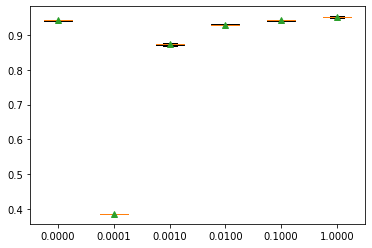

In [ ]:
for name, model in models.items():
    print(name)
    # evaluate the model and collect the scores
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize progress along the way
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()